In [1]:
%load_ext autoreload

In [28]:
%autoreload

import sys
sys.path.append('..')

import os
import pickle
import pprint
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import color.models as models
import color.utils.utils as utils
import color.hp_search as hp_search
import color.training as training

In [3]:
def save_hp_config(hp_config, overwrite=False):
    hp_dir = os.path.join('..', 'trained_models', 'hp', hp_config['hp_name'])
    config_path = os.path.join(hp_dir, 'hp_config.pickle')
    os.makedirs(hp_dir, exist_ok=overwrite)
    with open(config_path, 'wb') as x:
        pickle.dump(hp_config, x)
    print('Saved to "{}"'.format(config_path))

In [4]:
# HP config template
hp_config = {
    'hp_name': None,
    'model_key': None,
    'model_params': [],
    'training_params': {
        'draw_plots': True,
        'show_progress': True,
        'use_cuda': True,
    },
    'dataset_params': {
        'dataset': 'big',
        'emb_len': 300,
    }
}

In [5]:
# Test Hyperparams
hp_config_test = copy.deepcopy(hp_config)
hp_config_test['hp_name'] = 'hp_test'
hp_config_test['model_key'] = 'predict_color_rnn'
hp_config_test['model_params'] = [{
    'emb_dim': 50,
    'hidden_dim': 10,
    'num_layers': 1,
    'dropout': 0,
    'color_dim': 3,
    'nonlinearity': 'relu',
    'lr': 0.1,
    'momentum': 0.9,
    'weight_decay': 0
}]*2
if False:
    save_hp_config(hp_config_test)

In [26]:
# Hyperparameter generation for Sequence Models - Random Search

num_models = 15
model_params = []
model_key = 'predict_color_rnn' # One of: predict_color_rnn, predict_name_rnn
add_stop_word = False  # Only for model: predict_name_rnn

count = 0
while count < num_models:
    
    config = {
        'emb_dim': hp_config['dataset_params']['emb_len'],
        'name': 'rnn_{}'.format("{}".format(count+1).zfill(3))
    }
    
    # Model type
    config['model_type'] = str(np.random.choice(['RNN', 'LSTM']))
    config['nonlinearity'] = str(np.random.choice(['relu', 'tanh']))  # Only for model type RNN
    
    # Layer size and no of layers
    config['hidden_dim'] = int(np.random.choice(list(map(lambda x: int((config['emb_dim'] * x) / 100), range(50, 200, 50)))))
    config['num_layers'] = int(np.random.choice([1,2,3,4]))
    
    # Dropout; only for muilti-layer networks
    if config['num_layers'] > 1:
        config['dropout'] = -1
        while config['dropout'] < 0 or config['dropout'] > 0.4:
            config['dropout'] = float((0.2*np.random.randn()) + 0.2)
    else:
        config['dropout'] = 0
    
    # Learning rate (0.001 to 0.5)
    config['lr'] = float(min(0.5, max(0.001, np.power(10, np.random.randn()-1.5))))
    
    # Momentum (0.85 to 0.92)
    config['momentum'] = float(min(0.92, max(0.85, np.random.normal(0.9, 0.8))))
    
    # L2 regularization (1e-07 to 1e-04)
    config['weight_decay'] = min(1e-04, float(np.power(10, 2*np.random.randn()-5)))
    
    # Learning rate decay; Every 1 to 3 epochs; Factor (0.9 to 1)
    lr_step_size = int(np.random.choice(np.arange(1,3)))
    lr_gamma = float(max(0.9, 1 - np.power(10, -2*np.random.rand())))
    config['lr_decay'] = (lr_step_size, lr_gamma)
    
    # Loss function
    if model_key == 'predict_name_rnn':
        config['loss_fn'] = str(np.random.choice(['MSE', 'MSE_stop_word'])) if add_stop_word else 'MSE'
        
    # Validate hyperparameters and model size
    model_class, _ = models.get_model(model_key)
    model = model_class(**config)
    num_params = utils.get_trainable_params(model)
    print('Num params:', num_params)
    if num_params < 500_000 or num_params > 3_000_000:
        print('Num params out of range: {}. Skipping model:'.format(num_params))
        print(config)
        continue
        
    # Accept hyperparameters
    model_params.append(config)
    count += 1

# Print generate hyperparameters
for i, config in enumerate(model_params):
    print('Model', i+1)
    pprint.pprint(config)
    
# Save Hyperparams for sequence model
hp_config_seq = copy.deepcopy(hp_config)

hp_config_seq['hp_name'] = 'predict_color_seq_hp1'
hp_config_seq['model_key'] = model_key

hp_config_seq['training_params']['num_epochs'] = 6
hp_config_seq['training_params']['seq_len_first'] = True

hp_config_seq['dataset_params']['add_stop_word'] = add_stop_word

hp_config_seq['model_params'] = model_params

if True:
    save_hp_config(hp_config_seq, overwrite=False)

In [18]:
# Hyperparameter generation for Sequence Models - Grid Search

model_params = []
model_key = 'predict_name_rnn' # One of: predict_color_rnn, predict_name_rnn
add_stop_word = False  # Only for model: predict_name_rnn

# Base hyperparameters
config = {
    'emb_dim': 300,
    'lr': 0.001,
    'momentum': 0.91,
    'hidden_dim': 300,
    'num_layers': 3,
    'weight_decay': 1e-5,
    'lr_decay': (1, 0.9)
}
config_new = copy.deepcopy(config)
config_new['name'] = 'seq_base'
model_params.append(config_new)

# Adjustments to base hyperparameters
adj = [
    ['momentum', 'momentum_low', 0.87],
    ['momentum', 'momentum_high', 0.95],
    ['weight_decay', 'l2_nil', 0],
    ['weight_decay', 'l2_high', 1e-4],
    ['lr_decay', 'lr_decay_high', (1, 0.7)],
]
for a_prop, a_name, a_val in adj:
    config_new = copy.deepcopy(config)
    config_new['name'] = 'seq_' + a_name
    config_new[a_prop] = a_val
    model_params.append(config_new)

# Size adjustments
adj = [
    ['small', 100, 1],
    ['large', 400, 4],
]
for a_name, a_hdim, a_nlayers in adj:
    config_new = copy.deepcopy(config)
    config_new['name'] = 'seq_' + a_name
    config_new['hidden_dim'] = a_hdim
    config_new['num_layers'] = a_nlayers
    model_params.append(config_new)

# Print generate hyperparameters
for i, config in enumerate(model_params):
    print('Model', i+1)
    pprint.pprint(config)

# Save Hyperparams for sequence model
hp_config_seq = copy.deepcopy(hp_config)

hp_config_seq['hp_name'] = 'predict_name_seq_hp1_grid'
hp_config_seq['model_key'] = model_key

hp_config_seq['training_params']['num_epochs'] = 10
hp_config_seq['training_params']['seq_len_first'] = True

hp_config_seq['dataset_params']['add_stop_word'] = add_stop_word

hp_config_seq['model_params'] = model_params

if True:
    save_hp_config(hp_config_seq, overwrite=False)

In [32]:
# Generte Hyperparams for CNN model (Color predictions)

num_models = 15
model_params = []
model_key = 'predict_color_cnn'

count = 0
while count < num_models:
    
    config = {
        'max_words': 3,
        'name': 'cnn_{}'.format("{}".format(count+1).zfill(3))
    }
    
    # Conv + Pool blocks
    config['num_conv_layers'] = int(np.random.choice([1,2,3,4]))
    config['conv_kernel_size'] = int(np.random.choice([3,5,7,9]))
    config['conv_stride'] = int(np.random.choice([1,2,3]))
    
    config['pool_kernel_size'] = int(np.random.choice([3,5,7,9]))
    config['pool_stride'] = int(np.random.choice([1,2,3]))
   
    # Trailing linear layers
    config['num_linear_layers'] = int(np.random.choice([0,1,2,3,4]))
    config['linear_size_reduce'] = int(np.random.choice([1,2,3]))
    
    # Learning rate
    config['lr'] = float(min(0.5, max(0.001, np.power(10, np.random.randn()-1.5))))
    
    # Momentum (0.8 to 0.97)
    config['momentum'] = float(min(0.97, max(0.8, np.random.normal(0.9, 0.8))))
    
    # L2 regularization
    config['weight_decay'] = min(1e-05, float(np.power(10, 2*np.random.randn()-5)))
    
    # Learning rate decay
    lr_step_size = int(np.random.choice(np.arange(1,6)))
    lr_gamma = float(max(0.9, 1 - np.power(10, -2*np.random.rand())))
    config['lr_decay'] = (lr_step_size, lr_gamma)
    
    # Validate model strucure and no of parameters
    try:
        model_class, _ = models.get_model(model_key)
        model = model_class(**config)
    except AssertionError:
        print('Invalid model')
        print(config)
        continue
    num_params = utils.get_trainable_params(model)
    print('Num params:', num_params)
    if num_params < 500_000 or num_params > 3_000_000:
        print('Num params out of range: {}. Skipping model:'.format(num_params))
        print(config)
        continue
        
    # Accept hyperparameters
    model_params.append(config)
    count += 1
    
# Print hyperparameters
for i, config in enumerate(model_params):
    print('Model', i+1)
    pprint.pprint(config)
    
# Save Hyperparams for LSTM model (Color predictions)
hp_config_cnn = copy.deepcopy(hp_config)
hp_config_cnn['hp_name'] = 'predict_color_cnn_r2'
hp_config_cnn['model_key'] = 'predict_color_cnn'
hp_config_cnn['training_params']['num_epochs'] = 5
hp_config_cnn['model_params'] = model_params
if False:
    save_hp_config(hp_config_cnn, overwrite=False)

# Save Hyperparams for sequence model
hp_config_cnn = copy.deepcopy(hp_config)

hp_config_cnn['hp_name'] = 'predict_color_cnn_hp1'
hp_config_cnn['model_key'] = model_key

hp_config_cnn['training_params']['num_epochs'] = 6

hp_config_cnn['dataset_params']['max_words'] = 3
hp_config_cnn['dataset_params']['pad_len'] = 3

hp_config_cnn['model_params'] = model_params

if True:
    save_hp_config(hp_config_cnn, overwrite=True)

In [24]:
# Compare models

hp_name = 'predict_name_seq_hp1'
hp_dir = os.path.join(hp_search.hp_dir_base, hp_name)
config_path = os.path.join(hp_dir, 'hp_config.pickle')
hp_config = hp_search.load_model_configs(config_path)

# Load training parameters for all models
model_info = []
for model_params in hp_config['model_params']:
    save_dir = os.path.join(hp_search.hp_dir_base, hp_name, model_params['name'])
    if os.path.isdir(save_dir):
        model_info.append(training.load_training_params(save_dir))
    else:
        model_info.append(None)

# Create model comparison dataframe
model_params_df = pd.DataFrame(hp_config['model_params'])
model_params_df['epochs_trained'] = list(map(lambda m: None if m is None else len(m['epoch_train_losses']), model_info))
model_params_df['train_loss_min'] = list(map(lambda m: None if m is None or len(m['epoch_train_losses']) <= 0 else m['epoch_train_losses'][-1], model_info))
model_params_df['cv_loss_min'] = list(map(lambda m: None if m is None or len(m['epoch_cv_losses']) <= 0  else m['epoch_cv_losses'][-1], model_info))
model_params_df['training_time'] = list(map(lambda m: None if m is None else sum(m['epoch_durations']), model_info))
model_params_df = model_params_df.fillna('')

# Some remarks for model selection
model_params_df['remarks'] = [
    'good, about to saturate',#1
    'overfit',
    'ok, slow to converge',
    'poor',#4
    'poor',
    'good, slow to converge',
    'poor',#7
    'good, mild overfit but converging',
    'poor',
    'good, slow to converge',#10
]

if False:
    save_path = os.path.join(hp_dir, 'model_comparison.csv')
    model_params_df.to_csv(save_path)

model_params_df[['name', 'lr', 'hidden_dim', 'num_layers', 'dropout', 'nonlinearity', 'weight_decay', 
                 'momentum', 'train_loss_min', 'cv_loss_min', 'lr_decay', 'remarks']].sort_values('cv_loss_min')

,name,lr,hidden_dim,num_layers,dropout,nonlinearity,weight_decay,momentum,train_loss_min,cv_loss_min,lr_decay,remarks
7,rnn_008,0.002494,225,1,0.000000,relu,7.303276e-08,0.910000,0.151657,0.157444,"(2, 0.9)","good, mild overfit but converging"
1,rnn_002,0.009010,225,2,0.083029,tanh,1.000000e-06,0.800000,0.147300,0.161343,"(2, 0.9)",overfit
0,rnn_001,0.001000,600,4,0.253945,relu,1.000000e-06,0.910000,0.157965,0.161954,"(2, 0.9797120820765007)","good, about to saturate"
5,rnn_006,0.001000,450,1,0.000000,tanh,1.000000e-06,0.800000,0.159224,0.162421,"(2, 0.9)","good, slow to converge"
9,rnn_010,0.001000,225,3,0.096579,tanh,1.884157e-09,0.800000,0.159601,0.162528,"(2, 0.9)","good, slow to converge"
3,rnn_004,0.021637,600,2,0.218275,tanh,1.000000e-06,0.910000,0.147986,0.164173,"(1, 0.9)",poor
6,rnn_007,0.100000,300,1,0.000000,relu,1.000000e-06,0.800000,0.142181,0.164758,"(1, 0.9)",poor
2,rnn_003,0.001000,225,4,0.295649,tanh,1.000000e-06,0.800701,0.161160,0.165361,"(1, 0.9462830749466179)","ok, slow to converge"
4,rnn_005,0.100000,225,1,0.000000,relu,1.000000e-06,0.910000,0.230913,0.236760,"(2, 0.9653344048428644)",poor
8,rnn_009,0.100000,600,2,0.123173,relu,1.000000e-06,0.910000,0.344502,0.300437,"(2, 0.9828709929420816)",poor


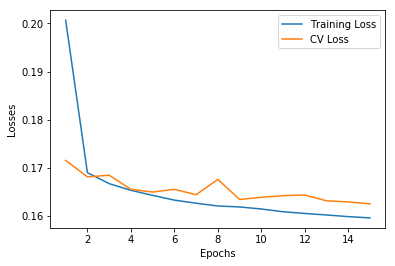

,dropout,emb_dim,hidden_dim,lr,lr_decay,momentum,name,nonlinearity,num_layers,weight_decay,epochs_trained,train_loss_min,cv_loss_min,training_time,remarks
9,0.096579,300,225,0.001,"(2, 0.9)",0.8,rnn_010,tanh,3,1.884157e-09,15,0.159601,0.162528,637.360285,


In [23]:
# Visualize train/cv errors for any model

def plot_losses(model_info):
    num_epochs = len(model_info['epoch_train_losses'])
    epochs = np.arange(num_epochs) + 1
    plt.plot(epochs, model_info['epoch_train_losses'], label='Training Loss')
    plt.plot(epochs, model_info['epoch_cv_losses'], label='CV Loss')
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.show()

model_info_dict = {m['name']: model_info[i] for i, m in enumerate(hp_config['model_params'])}
m = 'rnn_010'
plot_losses(model_info_dict[m])
model_params_df[model_params_df['name'] == m]

In [26]:
# Filter out some well performing models
filtered = model_params_df[['name', 'lr', 'hidden_dim', 'dropout', 'nonlinearity', 'weight_decay', 
                 'momentum', 'train_loss_min', 'cv_loss_min', 'remarks']]
filtered[filtered['remarks'].str.contains('good')]

,name,lr,hidden_dim,dropout,nonlinearity,weight_decay,momentum,train_loss_min,cv_loss_min,remarks
0,rnn_001,0.001000,600,0.253945,relu,1.000000e-06,0.91,0.157965,0.161954,"good, about to saturate"
5,rnn_006,0.001000,450,0.000000,tanh,1.000000e-06,0.80,0.159224,0.162421,"good, slow to converge"
7,rnn_008,0.002494,225,0.000000,relu,7.303276e-08,0.91,0.151657,0.157444,"good, mild overfit but converging"
9,rnn_010,0.001000,225,0.096579,tanh,1.884157e-09,0.80,0.159601,0.162528,"good, slow to converge"
